In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')

%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('archive/'):
    for i, filename in enumerate(filenames):
            print(os.path.join(dirname,filename))
            


archive/abengoa.csv
archive/acciona.csv
archive/acerinox.csv
archive/acs.csv
archive/atresmedia.csv
archive/banco-sabadell.csv
archive/bankinter.csv
archive/bbva.csv
archive/bme.csv
archive/caixabank.csv
archive/colonial.csv
archive/enags.csv
archive/fcc.csv
archive/ferrovial.csv
archive/grifols.csv
archive/iberdrola.csv
archive/inditex.csv
archive/indra.csv
archive/mapfre.csv
archive/mediaset.csv
archive/naturgy-energy.csv
archive/red-elctrica.csv
archive/repsol.csv
archive/sacyr.csv
archive/santander.csv
archive/siemens-gamesa.csv
archive/telefnica.csv


# Load Data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("archive/{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

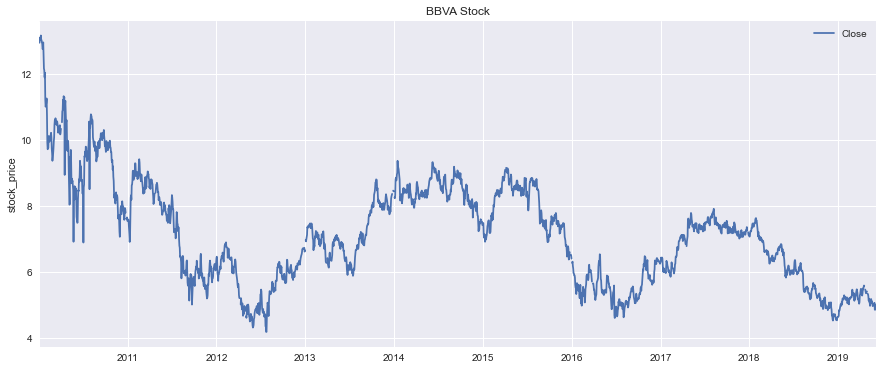

In [4]:
dates = pd.date_range('2010-01-04','2019-06-07',freq='B')
df1=pd.DataFrame(index=dates)
df_bbva=pd.read_csv("archive/bbva.csv", parse_dates=True, index_col=0)
df_bbva=df1.join(df_bbva)
df_bbva[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("BBVA Stock")
plt.show()

In [5]:
df_bbva=df_bbva[['Close']]
df_bbva.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460 entries, 2010-01-04 to 2019-06-07
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2412 non-null   float64
dtypes: float64(1)
memory usage: 103.0 KB


In [6]:
df_bbva=df_bbva.fillna(method='ffill') #method to treat empty data

scaler = MinMaxScaler(feature_range=(-1, 1)) #clamping data
df_bbva['Close'] = scaler.fit_transform(df_bbva['Close'].values.reshape(-1,1))



In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 80 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_bbva, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2142, 79, 1)
y_train.shape =  (2142, 1)
x_test.shape =  (238, 79, 1)
y_test.shape =  (238, 1)


In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
y_train.size(),x_train.size()

(torch.Size([2142, 1]), torch.Size([2142, 79, 1]))

# Build the structure of model

In [10]:
# Build model
#####################
#we changed this hyperparameter to test diferent options
input_dim = 1
hidden_dim = 48
num_layers = 3
output_dim = 1


# Here we define our model as a class
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True) #setting bidirectional

        # Readout layer
        self.fc = nn.Linear(hidden_dim*2, output_dim) #getting x2 hidden dimensions as it is bidirectional

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #getting x2 # of layers

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #getting x2 # of layers

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :]) 
        return out
    
modelBi = BiLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fnBi = torch.nn.MSELoss()

optimiser = torch.optim.Adam(modelBi.parameters(), lr=0.01)
print(modelBi)
print(len(list(modelBi.parameters())))
for i in range(len(list(modelBi.parameters()))):
    print(list(modelBi.parameters())[i].size())

BiLSTM(
  (lstm): LSTM(1, 48, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=96, out_features=1, bias=True)
)
26
torch.Size([192, 1])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 1])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 96])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 96])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 96])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 96])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([1, 96])
torch.Size([1])


In [11]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1  

for t in range(num_epochs):
    # Forward pass
    y_train_pred = modelBi(x_train)

    loss = loss_fnBi(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.04420875385403633
Epoch  20 MSE:  0.017259076237678528
Epoch  30 MSE:  0.0073090363293886185
Epoch  40 MSE:  0.00333884684368968
Epoch  50 MSE:  0.0025566332042217255
Epoch  60 MSE:  0.0021000136621296406
Epoch  70 MSE:  0.0019729030318558216
Epoch  80 MSE:  0.0018901744624599814
Epoch  90 MSE:  0.001810627174563706
Epoch  100 MSE:  0.0017472675535827875
Epoch  110 MSE:  0.001699866377748549
Epoch  120 MSE:  0.0016539555508643389
Epoch  130 MSE:  0.0016134819015860558
Epoch  140 MSE:  0.001578737748786807
Epoch  150 MSE:  0.0015503294998779893
Epoch  160 MSE:  0.0015273612225428224
Epoch  170 MSE:  0.0015085689956322312
Epoch  180 MSE:  0.0014933045022189617
Epoch  190 MSE:  0.0014812754234299064


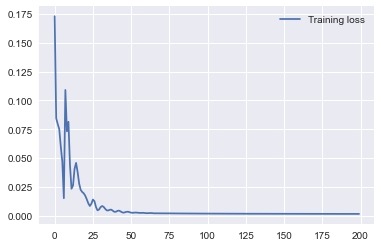

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
# make predictions
y_test_pred = modelBi(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.17 RMSE
Test Score: 0.09 RMSE


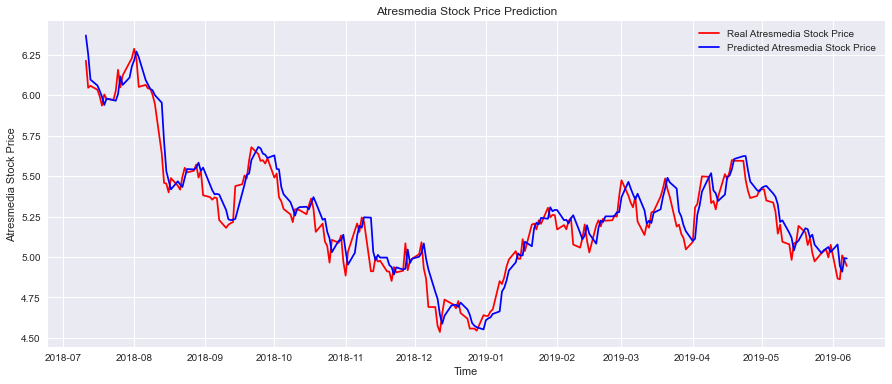

In [14]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_bbva[len(df_bbva)-len(y_test):].index, y_test, color = 'red', label = 'Real Atresmedia Stock Price')
axes.plot(df_bbva[len(df_bbva)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Atresmedia Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Atresmedia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Atresmedia Stock Price')
plt.legend()
plt.savefig('BBVA.png')
plt.show()